# Reformat the Data

In [4]:
import pandas as pd
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import json

# SUPPORTING FUNCTIONS

# retrieve binomial condition from item number
def item2condition(number):
    condNum = (number - 4) % 5
    if condNum % 3 == 0:
        return 1
    elif condNum % 3 == 1:
        return 2
    else:
        return 0
    
# decode the visual condition from the label
def get_vis_condition(label):
    condlist = label.split("+")
    return {'order': int(condlist[0]),
           'size1': int(condlist[1]),
           'size2': int(condlist[2]),
           'location': int(condlist[3])}

def get_all_vis_conditions(long_label):
    labels = long_label.split("_")
    label_list = []
    for i in range(3):
        label_list.append(get_vis_condition(labels[i]))
    return label_list

def get_feature(label_list, i, feature_name):
    return label_list[i][feature_name]

In [7]:
# read the data
data = pd.read_csv("../Data/Main/RSA_results.txt", comment='#', header=None, 
                   names=['Time', 'IPHash', 'Controller', 'Item', 'Element', 'Type', 'Group', 'Field', 'Value']) 
del data['Controller']
del data['Element']
del data['IPHash']
data = data[data['Field']!='_REACTION_TIME_']
data = data[data['Type']=='image']

data['Item'] = data['Item'].apply(item2condition)
data['Field'] = data['Field'].apply(get_all_vis_conditions)
data['Value'] = data['Value'].apply(get_vis_condition)
data = data.reset_index(drop=True)
data = data.rename(index=str, columns={"Time": "SUB", "Item": "WORD_ORDER", "Group": "ITEM"})
del data['Type']

# separate conditions

location_names = ['TOP', 'CENTER', 'BOTTOM']
feature_names = ['ORDER', 'SIZE_A', 'SIZE_B']
features = ['order', 'size1', 'size2']
for l in range(3):
    for f in range(3):
        col_name = feature_names[f] + '_' + location_names[l]
        data[col_name] = data['Field'].apply(get_feature, args=(l, features[f]))
data['CHOICE'] = data['Value'].apply(lambda x: x['location'])
data['CHOICE'] = data['CHOICE'].apply(lambda i: location_names[i])
data['ITEM'] = data['ITEM'].apply(lambda x: int(x))
del data['Field']
del data['Value']
data.head()

,SUB,WORD_ORDER,ITEM,ORDER_TOP,SIZE_A_TOP,SIZE_B_TOP,ORDER_CENTER,SIZE_A_CENTER,SIZE_B_CENTER,ORDER_BOTTOM,SIZE_A_BOTTOM,SIZE_B_BOTTOM,CHOICE
0,1513003540,0,24,2,60,120,1,120,60,2,120,60,CENTER
1,1513003540,2,21,1,120,120,1,120,60,2,120,60,TOP
2,1513003540,2,18,2,120,60,2,60,120,1,120,120,BOTTOM
3,1513003540,2,36,2,60,120,1,120,60,1,120,120,BOTTOM
4,1513003540,0,4,2,120,120,1,60,120,1,120,60,CENTER


In [8]:
# used for mixed effect regression analyses in R
data.to_csv('../Data/Processed/binomials_data.csv', index=False)

In [ ]:
# retrieve & save prior data
# used by mlogit in R to determine prior preferences used by the models 

def compare_size(size1, size2, order):
    """Returns -1 is the image on the left is larger,
    1 if the image on the right is larger, and 0 if they are the same size"""

    # make sure size1 refers to the left image
    if order != 1:
        tmp = size1
        size1 = size2
        size2 = tmp
    if size1 < size2:
        return 'SMALLER'
    elif size1 > size2:
        return 'LARGER'
    else:
        return 'EQUAL'
    
def get_relative_size(row):
    choice = row['CHOICE']
    return compare_size(row['SIZE_A_' + choice], row['SIZE_B_' + choice], row['ORDER_' + choice])

prior_data = data[data['WORD_ORDER']==0]
prior_data['CHOICE_SIZE'] = prior_data.apply(get_relative_size, axis=1) 
prior_data.to_csv('../Data/Processed/prior_data.csv', index=False)

In [29]:
### GO TO R, RUN PRIOR PREDICTION ANALYSES

# then convert results into webppl-readable format here
mlogit_prediction = pd.read_csv('../Data/Processed/predictions-mlogit.csv')
del mlogit_prediction['Unnamed: 0']
mlogit_prior = mlogit_prediction.values.tolist()
with open('../Data/Processed/mlogit_prior.txt', 'w') as f:
    json.dump(mlogit_prior, f)

# Prediction Scatterplots

In [13]:
# some extra processing
def find_order_match(row):
    for location in ['TOP', 'CENTER', 'BOTTOM']:
        row['ORDER_' + location + '_MATCH'] = (row['ORDER_' + location] == row['WORD_ORDER'])
    return row

# exclude prior elicitation condition
data_test = data[data['WORD_ORDER']!=0]
data_test = data_test.reset_index()
data_test = data_test.apply(find_order_match, axis=1)

In [14]:
# split data according to the combination of experimental conditions (order & size of 3 image pairs)
def get_data_subset(data, location, params):
    subset = data
    subset = subset[subset['ORDER_' + location + '_MATCH'] == params['order_match']]
    subset = subset[subset['SIZE_A_' + location] == params['size1']]
    subset = subset[subset['SIZE_B_' + location] == params['size2']]
    return subset

param_combos = []
for order_match in [True, False]:
    for sizes in [[60, 120], [120, 120], [120, 60]]:
        param_combos.append({'order_match': order_match, 'size1': sizes[0], 'size2': sizes[1]})

all_combos = itertools.permutations(param_combos, 3)
all_subsets = []
locations = ['TOP', 'CENTER', 'BOTTOM']

for combo in all_combos:
    subset = data_test
    for location, params in zip(locations, combo):
        subset = get_data_subset(subset, location, params)
    all_subsets.append(subset)

In [15]:
# used in the "Scatterplot Data" section of the model code
indices = []
for subset in all_subsets:
    indices.append(int(subset.index[0]))
    
with open('../Data/Processed/indices2plot.txt', 'w') as f1:
    json.dump(indices, f1)
    
### GO TO WEBPPL, run "Scatterplot Data" functions to get model predictions

In [16]:
# get participants' responses to each combination of experimental conditions
choices = []
for subset in all_subsets:
    total = len(subset)
    counts = subset['CHOICE'].value_counts()
    for pos in ['TOP', 'CENTER', 'BOTTOM']:
        if pos in counts.keys():
            choices.append(counts[pos] * 1.0 / total)
        else:
            choices.append(0)

In [17]:
# get model predictions 
# source data produced by the "Scatterplot Data" section of the model code
with open('../Data/Processed/plot_data_model0.txt', 'r') as f0:
    data_m0 = json.load(f0)
with open('../Data/Processed/plot_data_model1.txt', 'r') as f1:
    data_m1 = json.load(f1)
with open('../Data/Processed/plot_data_model2.txt', 'r') as f2:
    data_m2 = json.load(f2)
with open('../Data/Processed/plot_data_model1_noprior.txt', 'r') as f3:
    data_m1_noprior = json.load(f3)
with open('../Data/Processed/plot_data_model2_noprior.txt', 'r') as f4:
    data_m2_noprior = json.load(f4)

In [19]:
values_m0 = [item for sublist in data_m0 for item in sublist]
values_m1 = [item for sublist in data_m1 for item in sublist]
values_m2 = [item for sublist in data_m2 for item in sublist]
values_m1_noprior = [item for sublist in data_m1_noprior for item in sublist]
values_m2_noprior = [item for sublist in data_m2_noprior for item in sublist]

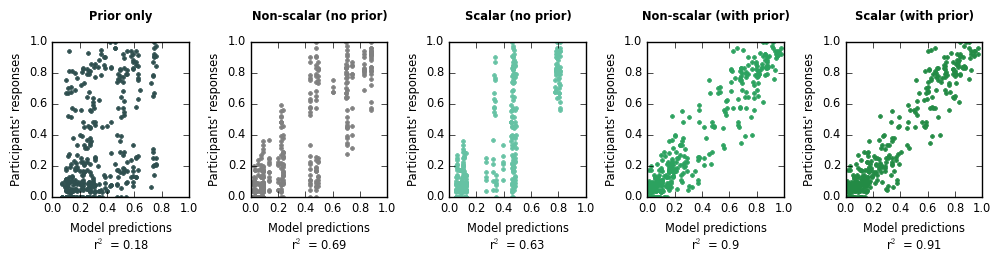

In [20]:
fig = plt.figure(figsize=(12,2))
values_all = [values_m0, values_m1_noprior, values_m2_noprior, values_m1, values_m2]
colors = ['darkslategray', 'gray', '#66c2a4', '#2ca25f', '#238b45']
model_names = ['Prior only', 'Non-scalar (no prior)', 
               'Scalar (no prior)', 'Non-scalar (with prior)', 'Scalar (with prior)']

for index, (values, name) in enumerate(zip(values_all, model_names)):
    r2 = round(np.corrcoef(values, choices)[0][1] ** 2, 2) 
    
    ax = plt.subplot(1, 5, index+1)
    plt.plot(values, choices, '.', color=colors[index])
    plt.title(name + '\n', fontsize=8.3, fontweight='semibold')
    plt.xlabel('Model predictions\nr' + r'$^2$ = ' + str(r2))
    plt.ylabel('Participants\' responses')
    plt.xlim([0, 1])

matplotlib.rcParams.update({'font.size': 8.3})
fig.subplots_adjust(wspace=.45)    

# Sample trial plot

In [27]:
# sample trials

SMALL = 60
LARGE = 120

def get_choice_stats(data, params_all):
    locations = ['TOP', 'CENTER', 'BOTTOM']
    subset = data
    for location, params in zip(locations, params_all):
        subset = get_data_subset(subset, location, params)
    results = subset['CHOICE'].value_counts() / len(subset)
    found_locations = results.index
    top = results['TOP'] if 'TOP' in found_locations else 0
    center = results['CENTER'] if 'CENTER' in found_locations else 0
    bottom = results['BOTTOM'] if 'BOTTOM' in found_locations else 0
    return [top, center, bottom]

order_only = {'order_match': True, 'size1': SMALL, 'size2': LARGE}
size_only_l = {'order_match': False, 'size1': LARGE, 'size2': SMALL}
size_only_e = {'order_match': False, 'size1': LARGE, 'size2': LARGE}
both_l = {'order_match': True, 'size1': LARGE, 'size2': SMALL}
both_e = {'order_match': True, 'size1': LARGE, 'size2': LARGE}

nothing = {'order_match': False, 'size1': SMALL, 'size2': LARGE}

def compare_conditions(ax, data, params1, params2, names1, names2):
    results1 = get_choice_stats(data, params1)
    results2 = get_choice_stats(data, params2)
    width = 0.25
    #colors = ['#fee391', '#fec44f', '#fe9929']   # orange
    #colors = ['#cbc9e2', '#9e9ac8', '#756bb1']    # purple
    colors = ['#6baed6', '#3182bd', '#08519c']   # blue
    for pos, (result, names) in enumerate(zip([results1, results2], [names1, names2])):
        plt.barh([pos + width], result[0], height=width, color=colors[0])
        plt.barh([pos], result[1], height=width, color=colors[1])
        plt.barh([pos - width], result[2], height=width, color=colors[2])   
        
    offset = width / 2
    ticks = [[pos + offset + width, pos + offset, pos + offset - width] for pos in range(2)]
    flatten = lambda l: [item for sublist in l for item in sublist]
    ticks = flatten(ticks)
    names1.extend(names2)
    plt.yticks(ticks, names1)
    plt.xlabel('Proportion of Choices')
    plt.ylim([-0.35, 1.6])
    plt.xlim([0, 1])

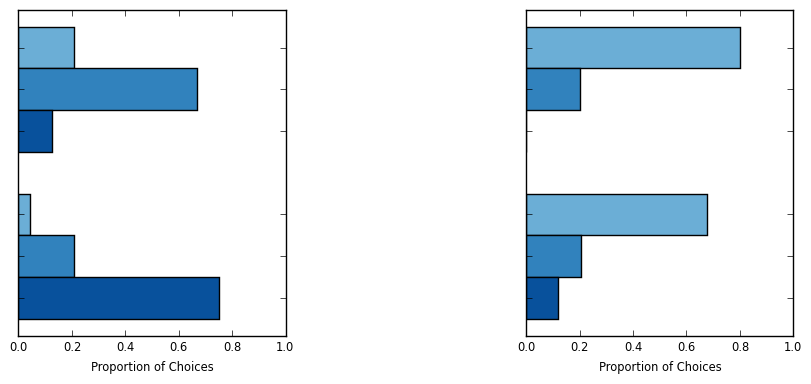

In [28]:
# see extra effect of size
params1 = [order_only, size_only_e, size_only_l]
params2 = [order_only, size_only_e, nothing]
params1names = ['left smaller', 'right equal', 'right larger']
params2names = ['left smaller', 'right equal', 'right smaller']

# see extra effect of order
params3 = [size_only_l, size_only_e, order_only]
params4 = [size_only_l, size_only_e, nothing]
params3names = ['right larger', 'right equal', 'left smaller']
params4names = ['right larger', 'right equal', 'right smaller']
dummy_names = ['', '', '']

fig = plt.figure(figsize=(10,4.2))
matplotlib.rcParams.update({'font.family': 'sans-serif'})
plt.yticks(fontsize=8)
ax = plt.subplot(121)
compare_conditions(ax, data, params3, params4, dummy_names, dummy_names)
#compare_conditions(ax, data, params3, params4, params3names, params4names)
#plt.title('Effect of order', fontsize=12)

ax = plt.subplot(122)
compare_conditions(ax, data, params1, params2, dummy_names, dummy_names)
#compare_conditions(ax, data, params1, params2, params1names, params2names)
#plt.title('Effect of size', fontsize=12)

fig.subplots_adjust(wspace=.9)